# Exercise Eigenvalues

In this notebook, we will talk about algorithms for computing Eigenvalues and Eigenvectors.

## Preparation

Import modules

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as scl
import scipy.sparse as scsp

### Create random matrices
At first, we introduce a short notation to generate random matrices.  
The dimension is a tuple (rows, cols). If rows=cols a short notation is possible such that:  
(n, n) = (n) = n

In [2]:
def get_dimension(dim):
    # converts short notion (only 1 int or 1 tuple for two times same index) into 2-tuple
    # INPUT : 2-tuple, 1-tuple or int
    # OUTPUT: 2-tuple
    if str(type(dim)) == "<class 'tuple'>":
        try:
            n = dim[1]
        except:
            n = dim[0]
        m = dim[0]
    else:
        m = dim
        n = dim
    return (m, n)


# Test function:
print(get_dimension((2, 3)), "should be: (2, 3)")
print(get_dimension(2), "should be: (2, 2)")
print(get_dimension((2)), "should be: (2, 2)")

(2, 3) should be: (2, 3)
(2, 2) should be: (2, 2)
(2, 2) should be: (2, 2)


In [3]:
def Create_random_matrix(dim, data_type="real"):
    # Returns a real or complex matrix with uniform or wide range distribution
    # INPUT :- dim:  number or 1-tupel or 2- tuple
    #        - data_type: "real or complex"
    #        - distribution "uniform" in [0,1) or "wide_range" in (-10^10, 10^10), approximated log distributed
    # OUTPUT: Matrix of dimension dim with real or complex entries

    dim = get_dimension(dim)

    A = np.random.random(dim)
    if data_type == "complex":
        A = A + 1j * np.random.random()
    if data_type == "symmetric":
        A = A + A.T
    if data_type == "diag_dominant":
        row_sum = np.sum(A, axis=1)
        A = A + A.T
        for i in range(dim[0]):
            A[i, i] = row_sum[i] + 0.5
    return A


# test function
A = Create_random_matrix(2, "complex")
print(A)
B = Create_random_matrix((2, 1))
print(B)

[[0.22054159+0.2171685j 0.19266453+0.2171685j]
 [0.08778641+0.2171685j 0.20375069+0.2171685j]]
[[0.35717142]
 [0.24995734]]


### Motivation

This can be skipped.
In this example we would like to find the eigen-frequencies of a membrane on a square.

For this, we discretize the Laplace operator via a finite difference approach and determine the eigenvalues of this discretization.

The Laplace equation is 
$$ \Delta u = 0$$
with $ \Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} $

We assume $u=0$ on $\partial \Omega$


### Setup Matrix


In [4]:
# Some index manipulations, used later
def index_2d_to_1d(i, j, n):
    """
    Convert 2D index to 1D index
    Input:
        i is the row index
        j is the column index
        n is the number of columns
    Output:
        1D index
    """
    return i * n + j


def index_1d_to_2d(index, n):
    """
    Convert 1D index to 2D index
    Input:
        index is the 1D index
        n is the number of columns
    Output:
        2D index
    """
    return (index // n, index % n)

Just execute the next cells, it's not important what happens inside.

In [5]:
def laplace_matrix_square(n):
    """
    returns the Laplace operator discretized on a grid of n*n points
    Input:
        n is the number of points in each dimension
    Output:
        A is the Laplace matrix
    """
    A = np.zeros((n * n, n * n), dtype=float)
    for i in range(n):
        for j in range(n):
            # inside the domain
            A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j, n)] = -4.0
            if i > 0 and j > 0 and i < n - 1 and j < n - 1:
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1.0
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1.0
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1.0
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1.0
                continue
            ## on the boundary
            # top boundary
            if i == 0:
                if j == 0:  # top left corner
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1

                elif j == n - 1:  # top right corner
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1

                else:
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1
                continue
            # bottom boundary

            if i == n - 1:
                if j == 0:  # bottom left corner
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1
                    continue
                elif j == n - 1:  # bottom right corner
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1
                    continue
                else:
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1
                    A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1
                    continue
            # left boundary
            if j == 0:
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j + 1, n)] = 1
            # right boundary
            if j == n - 1:
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i - 1, j, n)] = 1
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i + 1, j, n)] = 1
                A[index_2d_to_1d(i, j, n), index_2d_to_1d(i, j - 1, n)] = 1

    return A / n**2

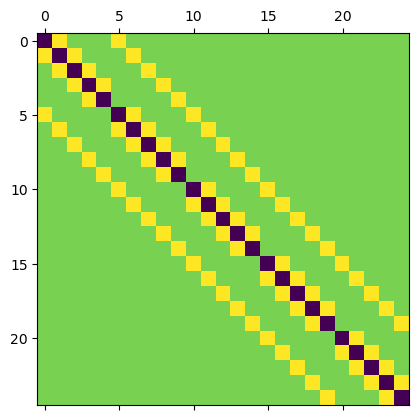

In [6]:
#### test
n = 5
A = laplace_matrix_square(n)
plt.matshow(A)

In [7]:
def plot_eigenfunctions(A, n_max=6):
    plot_row = n_max // 3 + np.min([n_max % 3, 1])
    print(plot_row)
    fig, ax = plt.subplots(plot_row, 3, figsize=(15, 5 * plot_row))
    n = int(np.sqrt(A.shape[0]))

    for i in range(n_max):
        B = np.zeros((n, n))
        for j in range(n**2):
            coords = index_1d_to_2d(j, n)
            B[coords[0], coords[1]] = A[j, i]
        # plot
        row = i // 3
        col = i % 3
        im = ax[row, col].matshow(B)
        ax[row, col].set_title("Eigenfunction " + str(i + 1))
        fig.colorbar(im, ax=ax[row, col])
    plt.show()

Eigenvalues: 
 [-0.02143594 -0.05071797 -0.05071797 -0.08       -0.09071797 -0.09071797
 -0.12       -0.12       -0.13071797 -0.13071797 -0.16       -0.16
 -0.16       -0.16       -0.16       -0.18928203 -0.18928203 -0.2
 -0.2        -0.22928203 -0.22928203 -0.24       -0.26928203 -0.26928203
 -0.29856406]
2


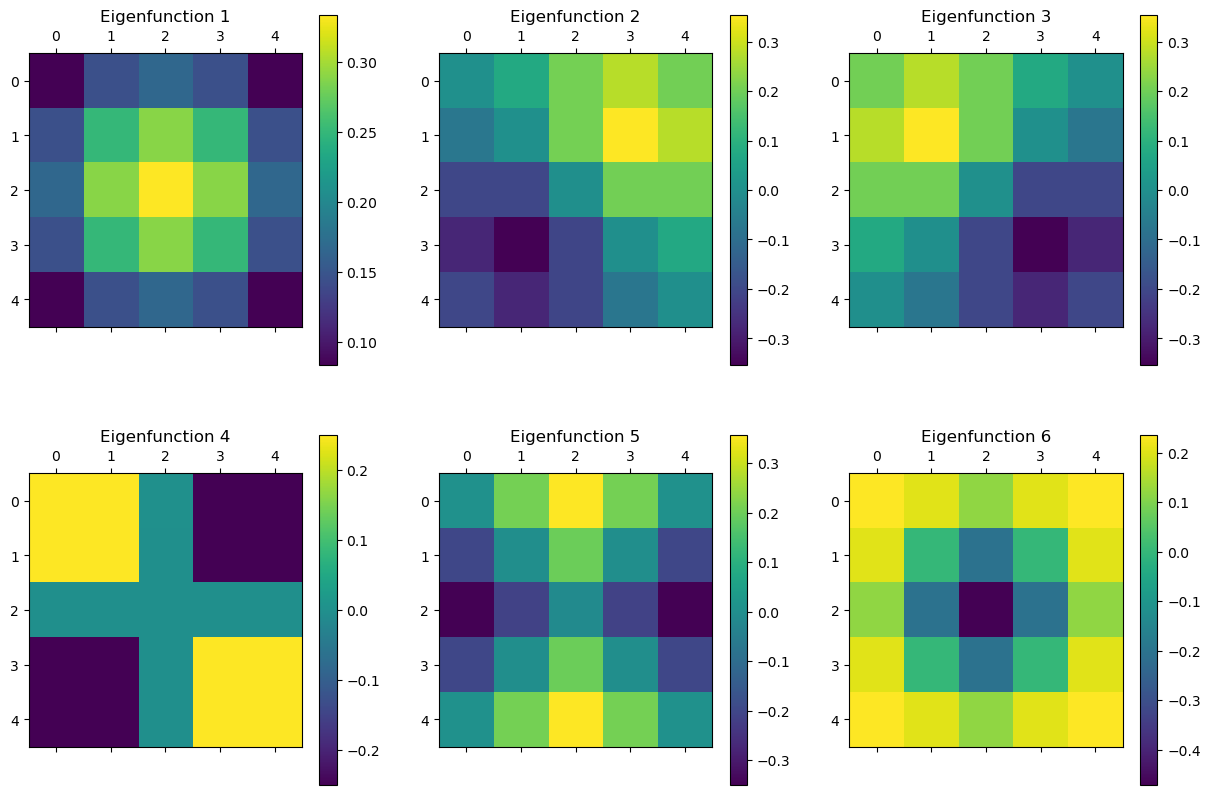

In [8]:
n = 5
A = laplace_matrix_square(n)
eigenvalues, eigenvectors = np.linalg.eig(A)
mask = np.argsort(eigenvalues)
eigenvalues = eigenvalues[mask[::-1]]
eigenvectors = eigenvectors[:, mask[::-1]]

print("Eigenvalues: \n", np.real(eigenvalues))

plot_eigenfunctions(eigenvectors)

<font color="red">Warning!</font>   
Please save all progress that you've made so far. Do save your results stored in other programs too.

The next cell is computationally expensive, so your computer could crash. After you saved everything, you can change `test_capacity` to True.

In [9]:
test_capacity = True

n = 4
times = []
while test_capacity:
    time_start = time.time()
    A = laplace_matrix_square(n)
    eigenvalues, eigenvectors = scl.eig(A)
    time_end = time.time()
    times.append(time_end - time_start)
    if (time_end - time_start) > 10:
        test_capacity = False
    n = n * 2
n_Max = n // 2
print("What??? Only " + str(n_Max))

What??? Only 64


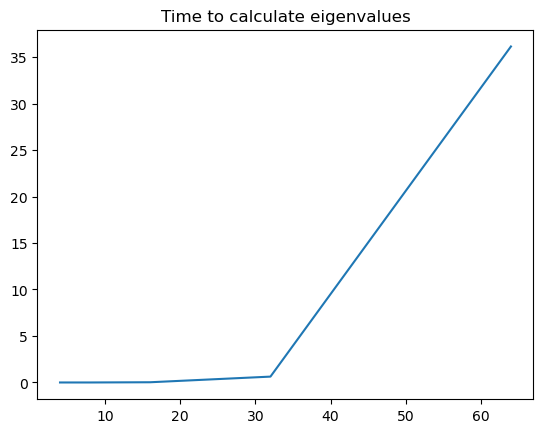

In [10]:
sizes = np.arange(2, len(times) + 2, 1)
plt.title("Time to calculate eigenvalues")
plt.plot(2 ** (sizes), times)

__Let's beat this!__


## Hessenberg form

Recall: A matrix can be transformed to Hessenberg form via similarity transformations. In the case of a symmetric matrix, the resulting matrix is tridiagonal. One kind of transformation is the Householder reflection.  To apply this, we define the Householder matrices. (See lessons on Monday, too)

### Householder matrix



$sign(v_1)$ is the sign of the first component. In the case, $v_1=0$ we choose sign=1. We calculate: $$ v_1 = v_1 + sign(v_1) \|v\|_2 $$
and  

$$Q_v = Id - 2 \cdot \frac{v v^T}{v^Tv} = Id -2 w w^T, $$

where $w = v/|v\|_2$.   


In [11]:
def Householder_matrix(v):
    # Create Matrix Q_v as described above.
    # INPUT: v 1d-array or 2d-array with one column or one row
    # OUPUT: Q Householdermatrix of v

    v = v.copy()  # do not overwrite original matrix
    n = len(v)
    v = v.reshape(
        (n)
    )  # reshape, because tensorprod gives different results for (n) and (n,1) dimension

    if np.linalg.norm(v) == 0:
        return np.eye(n)
    # modify first component
    if v[0] == 0:
        sign = 1
    else:
        sign = v[0] / np.abs(v[0])
    v[0] += sign * np.linalg.norm(v)  # linalg.norm calculates the l2 norm of a vector
    v = v / np.linalg.norm(v)
    # calc Q
    Q = np.eye(n) - 2.0 * np.tensordot(
        v, np.conj(v), axes=0
    )  # tensorprod does w w^T multiplication
    return Q

Now check, if the Householder Matrix has the right properties:
$$Q=Q^*=Q^{-1} $$
and
$$ Q_vv = \beta e_1$$ 
for some $\beta \in \mathbb{R}$. 

test case 1
maximal error: |Q-Q^*| = 	 0.0
maximal error: |QQ-id|=	 1.1102230246251565e-16
zero after reflection |Qv|=	 1.6653345369377348e-16

test case 2
maximal error: |Q-Q^*| = 	 0.0
maximal error |QQ-id|=	 1.1102230246251565e-16
2nd column ofQ under diagonal: 	 [0. 0.] should be zero

test case 3
maximal error Q-id=	 0.0


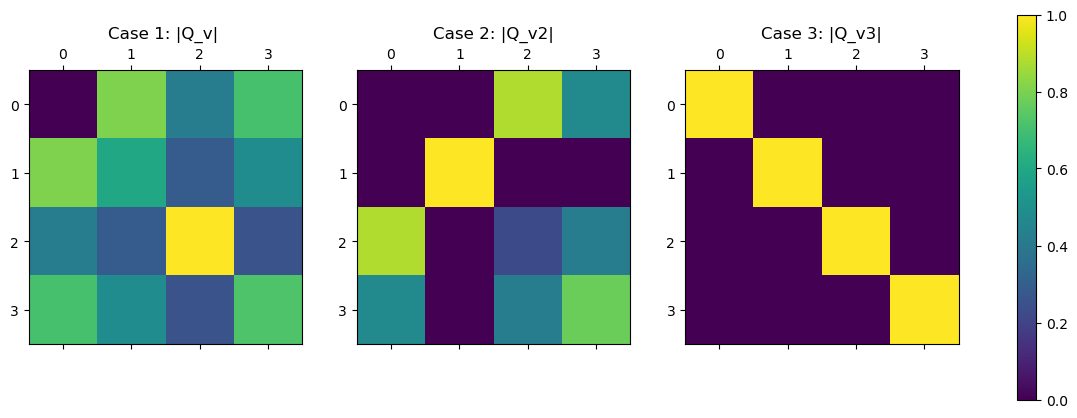

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# test case 1
print("test case 1")
v = Create_random_matrix((4, 1))
# print("v=\n", v)
Q = Householder_matrix(v)
im = ax[0].matshow(np.abs(Q))
ax[0].set_title("Case 1: |Q_v| ")
# fig.colorbar(im, ax=ax[0])
# check errors
error_sym = np.max(np.abs(Q - np.conj(Q.T)))
error_id = np.max(np.abs(Q @ Q - np.eye(v.shape[0])))
error_refl = np.max(np.abs((Q @ v)[1:]))
print("maximal error: |Q-Q^*| = \t", error_sym)
print("maximal error: |QQ-id|=\t", error_id)
print("zero after reflection |Qv|=\t", error_refl)
assert error_sym < 1e-10
assert error_id < 1e-10
assert error_refl < 1e-10

# test case 2
print("\ntest case 2")
v = Create_random_matrix((4, 1))
v[0:2] = np.array([0, 0]).reshape((2, 1))
# print("\n\n\nv_2=\n", v)
Q = Householder_matrix(v)
im = ax[1].matshow(np.abs(Q))
ax[1].set_title("Case 2: |Q_v2|")
# fig.colorbar(im, ax=ax[1])

print("maximal error: |Q-Q^*| = \t", np.max(np.abs(Q - np.conj(Q.T))))
print("maximal error |QQ-id|=\t", np.max(np.abs(Q @ Q - np.eye(v.shape[0]))))
print("2nd column ofQ under diagonal: \t", Q[2:, 1], "should be zero")
assert np.max(np.abs(Q[2:, 1])) <= 1e-10


# test case 3
print("\ntest case 3")
v = np.zeros(4)
Q = Householder_matrix(v)
im = ax[2].matshow(np.abs(Q))
ax[2].set_title("Case 3: |Q_v3|")
fig.colorbar(im, ax=ax)
# print("\n\nv_3= \n", v)
print("maximal error Q-id=\t", np.max(np.abs(Q - np.eye(4))))

### Hessenberg function

In [ ]:
def Hessenberg_form(A):
    # This function calculates the Hessenberg form via Housholder transformations of a complex matrix.
    # The entries of the inputmatrix will be overwritten by the Hessenbergform.
    # INPUT : real/complex squared Matrix A
    # OUTPUT: transfomation matrix

    n = A.shape[0]
    # store full transformation in matrix
    Q_res = np.eye(n, dtype=A.dtype)

    for i in range(n - 2):
        Q = Householder_matrix(A[i + 1 :, i])
        A[i + 1 :, :] = Q @ A[i + 1 :, :]
        A[:, i + 1 :] = A[:, i + 1 :] @ Q  # Q = Q* for householder matrices
        Q_res[i + 1 :, :] = Q @ Q_res[i + 1 :, :]
    return np.conj(Q_res.T)

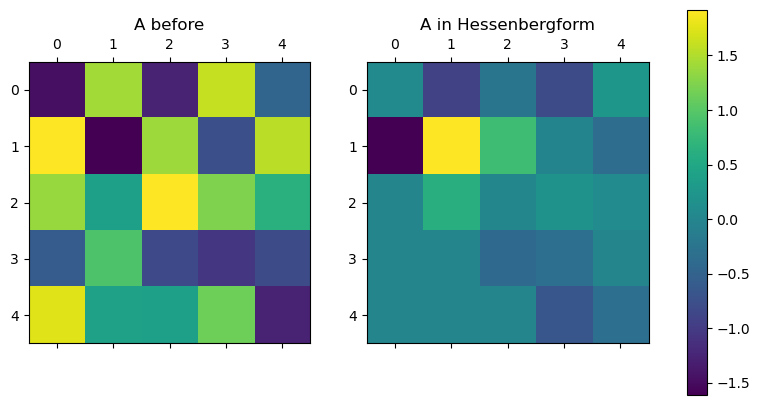

maximal error of Q*AQ-A_h	 2.220446049250313e-16


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
A = Create_random_matrix(5)
ax[0].matshow(A)
ax[0].set_title("A before")
B = A.copy()
Q = Hessenberg_form(A)
im = ax[1].matshow(A)
ax[1].set_title("A in Hessenbergform")
fig.colorbar(im, ax=ax)
plt.show()
print("maximal error of Q*AQ-A_h\t", np.max(np.abs(np.conj(Q.T) @ B @ Q - A)))

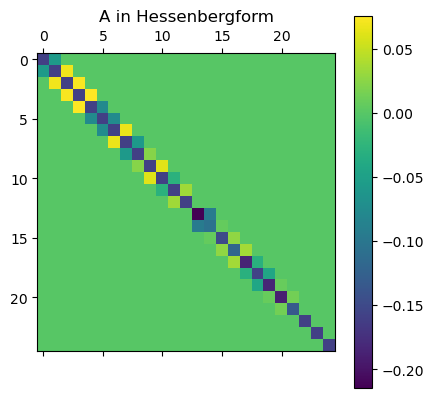

In [ ]:
n = 5
A = laplace_matrix_square(n)
Hessenberg_form(A)


plt.matshow(A)
plt.title("A in Hessenbergform")
plt.colorbar()
plt.show()

    
Now we have a good matrix to apply the QR-method. But first, we need the Givens rotation to efficiently calculate a QR decomposition.

## QR decomposition
### Givens rotations
Theory:  

$r_i = \sqrt{A_{i,i}^2 + A_{i+1, i}^2 }$  
$c_i = A_{i,i} / r_i$  
$s_i = A_{i+1, i} / r_i$

Due to readability, we omit the second index of the matrix for the rest of the calculation. It is always $i$

$ Q_i = \begin{pmatrix} c_i & s_i \\ -s_i & c_i \\ \end{pmatrix}$ such that 

$$ Q_i \cdot \begin{pmatrix} A_{i} \\ A_{i+1} \end{pmatrix} 
= \begin{pmatrix} c_i & s_i \\ -s_i & c_i \\ \end{pmatrix} \cdot 
\begin{pmatrix} A_{i} \\ A_{i+1} \end{pmatrix} 
= \begin{pmatrix} c_i A_{i} + s_i A_{i+1}\\ -s_i A_{i} + c_i A_{i+1} \end{pmatrix}
= \begin{pmatrix} (A_{i} A_{i} + A_{i+1}A_{i+1})/r_i \\ (-A_{i+1} A_{i} + A_{i} A_{i+1})/r_i
\end{pmatrix}
= \begin{pmatrix} r_i \\ 0
\end{pmatrix}
$$


(source: inspired by "On Computing Givens Rotations Reliably and Efficiently" from DAVID BINDEL, JAMES DEMMEL, WILLIAM KAHAN and OSNI MARQUES, https://www.cs.cornell.edu/~bindel/papers/2002-toms.pdf  
modified eq 1, because in the written way it gives wrong results)

In [16]:
def Givens_rotation(v):
    # This function calculates a rotation matrix,
    # such that the lower component of a 2-dimensional vector is 0
    # This is the complex version
    # INPUT : 2-dimensional vector
    # OUTPUT: 2x2-matrix

    v = v.copy()  # not overwrite the matrix elements
    v = v.reshape((2))  # such that entries are callable
    a = v[0]
    b = v[1]
    r = np.sqrt(a * np.conj(a) + b * np.conj(b))
    Q = np.array([[np.conj(a), np.conj(b)], [-b, a]]) / r
    return Q

In [17]:
v = Create_random_matrix((2, 1))
print("v=\n", v)
Q = Givens_rotation(v)
print("Q=\n", Q)
print("Qv = \n", Q @ v)

v=
 [[0.44551452]
 [0.21117906]]
Q=
 [[ 0.90362335  0.42832797]
 [-0.42832797  0.90362335]]
Qv = 
 [[ 4.93031217e-01]
 [-2.77555756e-17]]


The next milestone to a QR-iteration is the QR-decomposition of a Hessenberg matrix.

In [18]:
def QR_decomposition_Hess(A):
    # This function calculates the QR decomposition of a matrix in Hessenberg form and store the values of R in A
    # INPUT : A, nxn matrix in Hessenberg form
    # OUTPUT: Q*, nxn matrix, orthogonal

    n = A.shape[0]
    Q_res = np.eye(n, dtype=A.dtype)
    for i in range(n - 1):
        Q = Givens_rotation(A[i : i + 2, i])
        A[i : i + 2, i:] = Q @ A[i : i + 2, i:]
        Q_res[i : i + 2, :] = Q @ Q_res[i : i + 2, :]
    return np.conj(Q_res.T)

maximal error |QR-A|: 	 5.551115123125783e-17


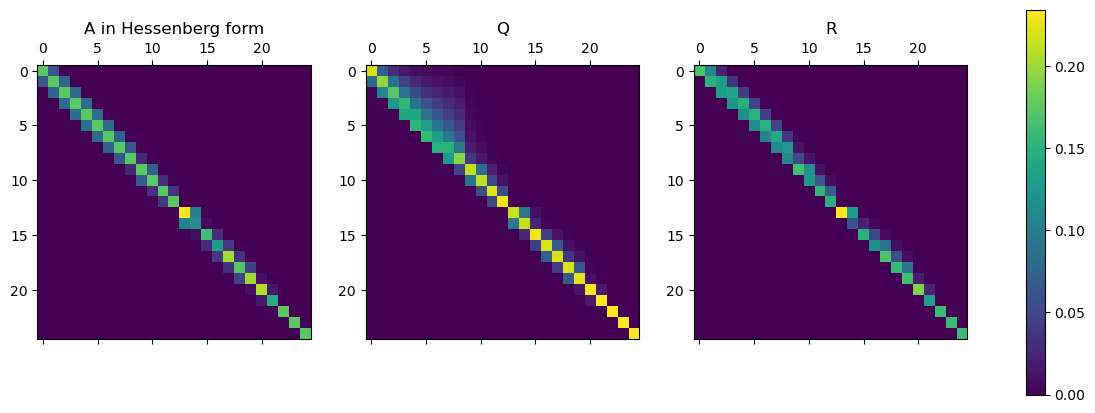

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

A = laplace_matrix_square(5)
Q_1 = Hessenberg_form(A)
B = A.copy()
# original matrix
ax[0].matshow(np.abs(A))
ax[0].set_title("A in Hessenberg form")

Q_2 = QR_decomposition_Hess(A)
# Q
ax[1].matshow(np.abs(Q_2))
ax[1].set_title("Q")
# R
im = ax[2].matshow(np.abs(A))
ax[2].set_title("R")
fig.colorbar(im, ax=ax)
error_qr = np.max(np.abs(Q_2 @ A - B))
print("maximal error |QR-A|: \t", error_qr)
assert error_qr < 1e-10

Now we have all parts together to do the QR-iteration. It will be a bit slow, but it will work.

### QR Iteration

$A_0= Q_0R_0$ (QR decomposition) $\Rightarrow R_0 = Q_0^T A_0$  
Define $A_1 = R_0Q_0 = Q_0^T A_0 Q_0 $  
$A_1= Q_1R_1$ (QR decomposition) and define $A_2 = R_1Q_1 = Q_1^TA_1 Q_1=Q_1^T Q_0^T A_0 q_0 Q_1$
...  
$A_n = Q_{n-1}^T Q_{n-2}^T \cdots Q_{1}^T A_0 Q_{1} \cdots Q_{n-2} Q_{n-1} = Q^TA_0Q$  
$Q = Q_{1} \cdots Q_{n-2} Q_{n-1}$  

This scheme is called QR iteration.

In [20]:
def QR_iteration_slow(A, eps=1e-6, max_Iterations=10000):
    # This function iterates the basic QR algorithm, until either the entries on the first sub diagonal
    # are small enough or Max iter reached The matrix A will be overwritten.
    # INPUT : - A: squared Matrix in hessenberg form
    #         - eps: if no diag entry changes more than eps, than the algorithm is converged
    #         - max_iterations: If this number is reached, it aborts the iteration and gives a warning
    # OUTPUT: - Q, nxn Matrix, similarity transformation
    #         - Iter : number of Iterations

    # define values, for the computation

    n = A.shape[0]
    Iter = 0
    error_ev = 1
    diagvals = np.diag(A).copy()
    Q_res = np.eye(n)

    # start QR iteration
    while error_ev > eps and Iter < max_Iterations:
        Q_2 = QR_decomposition_Hess(A)
        A[:, :] = A @ Q_2
        Q_res[:, :] = Q_res @ Q_2
        Iter += 1
        # preparation for next iteration
        error_ev = np.max(np.abs(diagvals - np.diag(A)))
        diagvals = np.diag(A).copy()

    if Iter == max_Iterations:
        print("Warning: Algorithm may not converged.")
    return Q_res, Iter

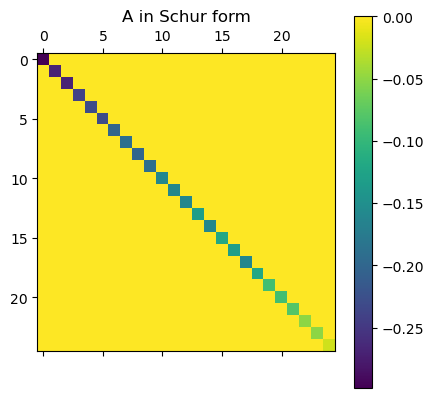

Iterations:			 395
eigenvalues		 [-0.29856406 -0.26928203 -0.26928203 -0.24       -0.22928203 -0.22928203
 -0.2        -0.18928203 -0.2        -0.18928203 -0.16       -0.16
 -0.15999997 -0.130718   -0.15999902 -0.12000124 -0.13071771 -0.15999999
 -0.12000001 -0.09071797 -0.09071797 -0.08       -0.05071797 -0.05071797
 -0.02143594]
true eigenvalues:	 [-0.29856406 -0.26928203 -0.26928203 -0.24       -0.22928203 -0.22928203
 -0.2        -0.2        -0.18928203 -0.18928203 -0.16       -0.16
 -0.16       -0.16       -0.16       -0.13071797 -0.13071797 -0.12
 -0.12       -0.09071797 -0.09071797 -0.08       -0.05071797 -0.05071797
 -0.02143594]
Max error of eigenvalues:	 1.2412057576044466e-06


In [21]:
A = laplace_matrix_square(5)
Q_Hess = Hessenberg_form(A)

B = A.copy()
Q, Iter = QR_iteration_slow(A, max_Iterations=10000)
plt.matshow(A)
plt.title("A in Schur form")
plt.colorbar()
plt.show()

w, v = np.linalg.eig(A)
print("Iterations:\t\t\t", Iter)
print("eigenvalues\t\t", np.diag(A))
print("true eigenvalues:\t", np.sort(w))
error_eigenval = np.max(np.abs(np.sort(w) - np.sort(np.diag(A))))
print("Max error of eigenvalues:\t", error_eigenval)
assert error_eigenval < 1e-4

#### Speed test
Warning: Again be cautious. The Cell is a runtime test.

In [22]:
test_capacity = True

n = 4
times = []
while test_capacity:
    print(n)
    time_start = time.time()

    A = laplace_matrix_square(n)
    Hessenberg_form(A)
    Q, iter = QR_iteration_slow(A)
    time_end = time.time()
    times.append(time_end - time_start)
    if (time_end - time_start) > 10:
        test_capacity = False
    n = n * 2
n_Max_selfwritten = n // 2
print(
    "Our self written code is just " + str(n_Max // n_Max_selfwritten) + "times slower."
)

4
8
16
Our self written code is just 4times slower.


This is not bad! We have still some space for improvement

#### Quality of Convergence 
Maybe, we can learn something from "How the Eigenvalues converge". For this, we plot diagonal entries over time. Ignore all the warnings.

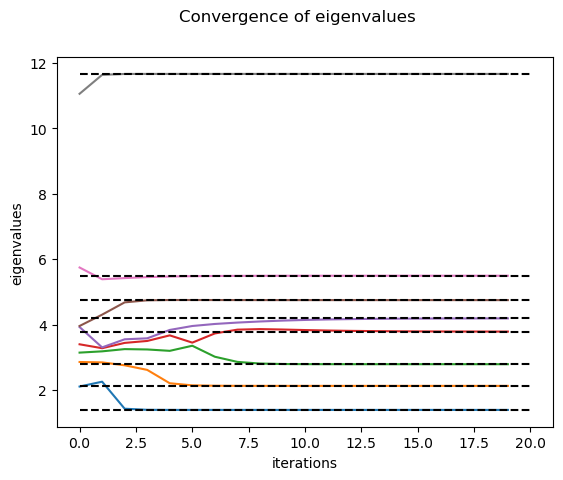

In [23]:
# prepare experiment:
n = 8
A = Create_random_matrix(n, "diag_dominant")

# for comparison:
w, v = np.linalg.eig(A.copy())
w = np.sort(w)
Q_Hess = Hessenberg_form(A)

max_Iterations = 20
convergence_eigenvals = {}  # dict
B = A.copy()
improvement_diag = np.zeros((n, max_Iterations))
for j in range(max_Iterations):
    Q, Iter = QR_iteration_slow(B, max_Iterations=2)
    improvement_diag[:, j] = np.sort(np.diag(B.copy()))


# plot over iterations
fig, ax = plt.subplots()
fig.suptitle("Convergence of eigenvalues")
ax.plot(np.arange(max_Iterations), improvement_diag.T)
ax.hlines(w, xmin=0, xmax=max_Iterations, colors="k", linestyles="dashed")
ax.set_xlabel("iterations")
ax.set_ylabel("eigenvalues")

# ax.set_xscale("log")
plt.show()

What do you observe?
- Which eigenvalues converge the fastest? 
- Which need more time?
- Is there a relation between the distance to the top and bottom of the figure?

#### Solution:
The largest and smallest eigenvalues converge faster than the neighbouring ones.

## On Optimization
But we aim for more efficiency! 
We realize:  

1. In lecture this morning, Celine told something about shifts? Can we use them?
2. Deflation...? Was there something?


### Shifts
The convergence rate of the QR method is
$$\frac{\lambda_{n-1}}{\lambda_n}.$$
This ratio can be very small. If we guess $\sigma \approx \lambda_n$, we can speed up the convergence by shifting
$$\frac{|\lambda_{n-1}-\sigma|}{|\lambda_n -\sigma|} >> 1. $$

But how do we get a good guess for $\sigma$? Different people found different answers:

- Rayleigh: $\sigma = A[n,n]$
- Wilkinson: $\sigma = \lambda_{min}(A[n-1:n, n-1:n])$, i.e. the smallest eigenvalue of lower right 2x2 Matrix. This can be calculated analytically.
- Further shifts are possible, including multi-shifts.
- Zero Shift: No shift at all.

In the following, please ignore any `ComplexWarnings`.  

EXERCISE: Implement some shifts.
Note: It's totally fine to just implement the Rayleigh shift.

In [24]:
def evaluate_shift(A, shift_type="Zero"):
    # This function returns different types of shifts.
    # INPUT : A: submatrix of size 2x2
    #       : Type of shift(Zero, Rayleigh, Wilkinson(?))
    # OUTPUT: a number which approximates an eigenvalue.
    if shift_type == "Zero":
        return 0
    # HERE your code

    else:
        print("Warning: No valid shift type, no shift used")
        return 0

Next, test your shifts. Do they behave as expected?
##### Solution
The shifts behave as expected, if they are close to eigenvalues of 2x2 Matrix. At least the real part.

In [25]:
# test the shifts, that were suggested above
A = Create_random_matrix(2)
print(A)
sigma1 = evaluate_shift(A)
print("No shift:\n sigma =", sigma1)
sigma2 = evaluate_shift(A, "Rayleigh")
print("Raiyleigh shift:\n sigma=", sigma2)
sigma3 = evaluate_shift(A, "Wilkinson")
print("Wilkonson shift:\n sigma=", sigma3)
w, v = np.linalg.eig(A)
print("compare to eigenvalues:", w)
print("No valid input:\n")
sigma5 = evaluate_shift(A, "blabla")

[[0.21869279 0.75192577]
 [0.62725637 0.27449856]]
No shift:
 sigma = 0
Raiyleigh shift:
 sigma= 0
Wilkonson shift:
 sigma= 0
compare to eigenvalues: [-0.44073889  0.93393024]
No valid input:



EXERCISE: Let us test our first improvement. For this, we have to modify the QR algorithm. Do you know how?  
Bonus for fast persons: You can add an additional feature, a kind of deflation. For this, restrict the matrix by slicing to the part, where the diagonal entries change. This will give you another speed up.  
This kind of restrict will be done by deflation later anyway.

In [26]:
def QR_iteration_shift(
    A, eps=1e-6, max_Iterations=10000, shift="Zero", suppress_warning=False
):
    # This function iterates the QR algorithm using shifts and a first glance of deflation.
    # I titerates, until either Max iter reached or
    # the values on the diagonal are
    # converged. The matrix A will be overwritten.
    # INPUT : - A: squared Matrix in hessenberg form
    #         - eps: if no diag entry changes more than eps, than the algorithm is converged
    #         - max_iterations: If this number is reached, it aborts the iteration and gives a warning
    #         - shift: accelerate convergence, types: Zero, Wilkinson, Francis, Rayleigh, None,
    #                 if None Wilkinson or Francis will be selected
    # OUTPUT: - Q, nxn Matrix, similarity transformation
    #         - Iter : number of Iterations

    # define values, for the computation
    n = A.shape[0]
    Iter = 0
    error_ev = 1
    diagvals = np.diag(A).copy()
    Q_res = np.eye(n, dtype=A.dtype)

    # start QR iteration
    while error_ev > eps and Iter < max_Iterations:
        # print(Iter, min_pos_not_converged, max_pos_not_converged)

        # evaluate shifts

        # HERE your code

        # QR iteration including shifts

        # HERE your code

        Iter += 1
        # preparation for next iteration
        error_ev = np.max(np.abs(diagvals - np.diag(A)))
        indices_not_converged = np.where(np.abs(diagvals - np.diag(A)) > eps)[0]
        if len(indices_not_converged) == 0:
            break

        diagvals = np.diag(A).copy()

    if not suppress_warning and Iter == max_Iterations:
        print("Warning: Algorithm may not converged.")
    return Q_res, Iter

Let's check the implementation:

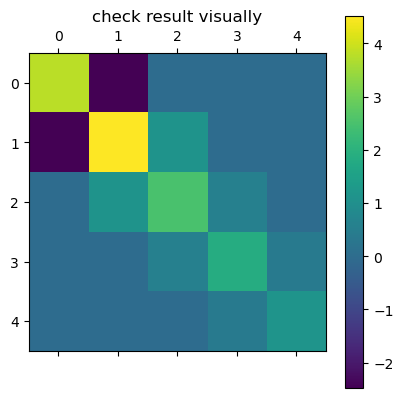

Iterations:			 1
true eigenvalues:	 [6.82970525 3.00598295 1.91473    1.18844078 0.87825629]
eigenvalues		 [4.51564579 3.80397158 2.50717081 1.84462406 1.14570303]
Max error of eigenvalues:	 2.31405945696143


In [27]:
n = 5
A = Create_random_matrix(n, "diag_dominant")
Q_Hess = Hessenberg_form(A)
w, v = np.linalg.eig(A)
B = A.copy()
Q, Iter = QR_iteration_shift(A, max_Iterations=10000, shift="Rayleigh")
eigenvalues = np.diag(A)
mask = np.argsort(eigenvalues)
eigenvalues = eigenvalues[mask[::-1]]
eigenvectors = eigenvectors[:, mask[::-1]]

plt.matshow(A)
plt.title("check result visually")
plt.colorbar()
plt.show()


print("Iterations:\t\t\t", Iter)

print("true eigenvalues:\t", w)
print("eigenvalues\t\t", eigenvalues)
error_eigenval = np.max(np.abs(np.sort(w) - np.sort(eigenvalues)))
print("Max error of eigenvalues:\t", error_eigenval)

EXERCISE: Test the different shifts.

In [28]:
# prepare experiment:
n = 15
A = Create_random_matrix(n, "diag_dominant")
# for comparison:
w, v = np.linalg.eig(A.copy())
w = np.sort(w)
Q_Hess = Hessenberg_form(A)
# HERE: modify the following list of shifts
list_shifts = ["Zero"]
print("shifts", "  iterartions", " error eigenvalues")
for shift in list_shifts:
    B = A.copy()
    Q, Iter = QR_iteration_shift(B, max_Iterations=10000, shift=shift)
    eigenvalues = np.sort(np.diag(B))
    error_eigenval = np.max(np.abs(w - eigenvalues))
    print(shift, Iter, error_eigenval)

shifts   iterartions  error eigenvalues
Zero 1 3.3384418889134047


Watch the convergence of the eigenvalues:


shifts   iterartions  error eigenvalues


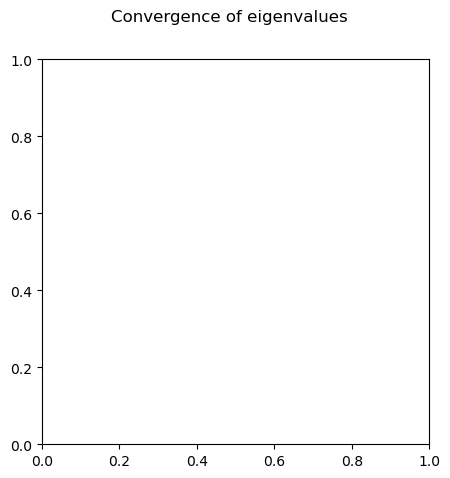

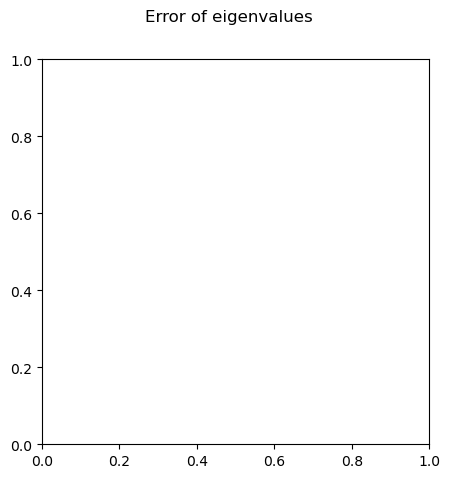

In [29]:
# prepare experiment:
n = 15
A = Create_random_matrix(n, "diag_dominant")

# for comparison:
w, v = np.linalg.eig(A.copy())
w = np.sort(w)
Q_Hess = Hessenberg_form(A)

# HERE modify the list of shifts
list_shifts = ["Zero"]
print("shifts", "  iterartions", " error eigenvalues")

max_Iterations = 100
convergence_eigenvals = {}  # dict
for i, shift in enumerate(list_shifts):
    B = A.copy()
    improvement_diag = np.zeros((n, max_Iterations))
    for j in range(max_Iterations):
        Q, Iter = QR_iteration_shift(
            B, max_Iterations=2, shift=shift, suppress_warning=True
        )
        improvement_diag[:, j] = np.sort(np.diag(B.copy()))
    convergence_eigenvals[shift] = improvement_diag


############
# plotting #
############


# plot over iterations
fig, ax = plt.subplots(1, len(list_shifts), figsize=(5 * len(list_shifts), 5))
fig.suptitle("Convergence of eigenvalues")
try:
    for i, shift in enumerate(list_shifts):
        ax[i].plot(np.arange(max_Iterations), convergence_eigenvals[shift].T)
        ax[i].hlines(w, xmin=0, xmax=max_Iterations, colors="k", linestyles="dashed")
        ax[i].set_xlabel("iterations")
        ax[i].set_ylabel("eigenvalues")
        ax[i].set_title(shift)
        ax[i].set_xscale("log")
    plt.show()
except TypeError:
    pass

fig, ax = plt.subplots(
    1, len(list_shifts), figsize=(5 * len(list_shifts), 5), sharey=True
)
fig.suptitle("Error of eigenvalues")
try:
    for i, shift in enumerate(list_shifts):
        for j in [0, 4, 8, 12, 14]:
            ax[i].plot(
                np.arange(max_Iterations),
                np.abs(convergence_eigenvals[shift][j, :] - w[j]),
                label=str(np.round(w[j], 2)),
            )
        ax[i].hlines(
            1e-6,
            xmin=0,
            xmax=max_Iterations,
            colors="k",
            linestyles="dashed",
            label="eps",
        )
        ax[i].set_xlabel("iterations")
        ax[i].set_ylabel("eigenvalues")
        ax[i].set_title(shift)
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].legend()

    plt.show()
except TypeError:
    pass

EXERCISE: The x scale is logarithmic. What do you observe?

#### Solution:



### Deflation

Recall: The QR-iteration is another way of the power method. For a matrix 
$$ A=\begin{pmatrix} C & R \\  & D \\ \end{pmatrix}$$ 
with the submatrices $D$, $C$ both square matrices and $R$ a rectangular matrix, 
we calculate

$$ A^2 = \begin{pmatrix} C & R \\  & D \\ \end{pmatrix} \cdot \begin{pmatrix} C & R \\  & D \\  \end{pmatrix} = \begin{pmatrix} C^2 & * \\  & D^2 \\  \end{pmatrix}$$
This can easily be generalized to $n$ powers.
If we split up the problem into two or more subproblems, we will save a lot of work.

It's possible to neglect values on the subdiagonal, if 

$$ |A_{i+1,i}| \leq \epsilon ( |A_{i,i}|+|A_{i+1,i+1}|) $$
for some $\epsilon>0$.  
A zero on the subdiagonal splits the matrix in two submatrices, which can be iterated independent of each other.

EXERCISE:
Please try to understand the next functions until you. What has changed? Why were the changes done? 



##### Solution


In [30]:
def Deflation(A, eps=1e-10):
    # returns list with indices, at which  the subdiag of A is zero or neglectable
    # INPUT : -A ,nxn matrix
    #         - eps, a relativ threashold indicating, if an entry vanishes
    # OUTPUT: list of columns of the entries on the first subdiagonal, that vanish

    # get values of diag and subdiag
    diag = np.abs(np.diag(A)).copy()
    subdiag = np.abs(np.diag(A, k=-1)).copy()
    # values, at which deflation makes sense
    compare_value = eps * (diag[:-1] + diag[1:])
    # indexarray to return the positions
    n = len(subdiag)
    positions = np.arange(n)
    # checks, if deflation should be applied,
    pos_zeros_long = np.where(subdiag < compare_value, positions, -1)
    # just give the values of the deflation
    pos_zeros = pos_zeros_long[pos_zeros_long > -1]
    return pos_zeros

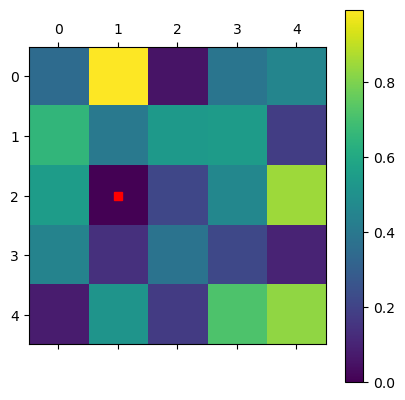

Deflations in column [1] (red point)


In [31]:
A = Create_random_matrix(5)

A[2, 1] = 0
plt.matshow(np.abs(A))
plt.colorbar()
plt.plot(1, 2, "rs")
plt.show()
x = Deflation(A)
print("Deflations in column", x, "(red point)")

Now, we can cut the matrix into pieces.

In [32]:
def Split(A, col_zeros, offset=0):
    # this function splits a matrix into smaller matrices at the position of vanishing elements, such that
    # QR iteration gives the same result. It ignores 1 dimensional blocks in the complex case and 2 dim, real
    # blocks, if the eigenvalues of this block are complex
    # INPUT : - A: nxn matrix
    #         - col_zeros: list with the columns of the subdiagonal, which vanish
    #         - offset: the row (and the column) from the position of the original matrix
    # OUTPUT: list of tuples with first part is the submatrix and the second the offset

    lst = []
    n = A.shape[0]
    recent_zero = 0
    # switch from column to row entries of the zeros
    row_zeros = [i + 1 for i in col_zeros]

    for i in range(len(col_zeros)):
        if row_zeros[i] - recent_zero > 1:  # can't be eigenvalue block
            lst.append(
                (
                    A[recent_zero : row_zeros[i], recent_zero : row_zeros[i]],
                    recent_zero + offset,
                )
            )
        recent_zero = row_zeros[i]

    # last block of matrix
    if n - recent_zero > 1:
        lst.append((A[recent_zero:, recent_zero:], recent_zero + offset))

    return lst

Assume zeros at positions : [0, 2, 5]


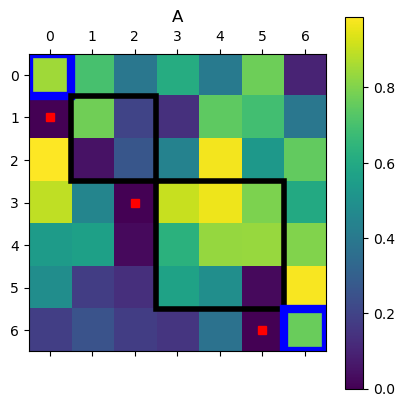

 red dots are set to 0, blue boxes are eigenvalues. The two black boxes remain.


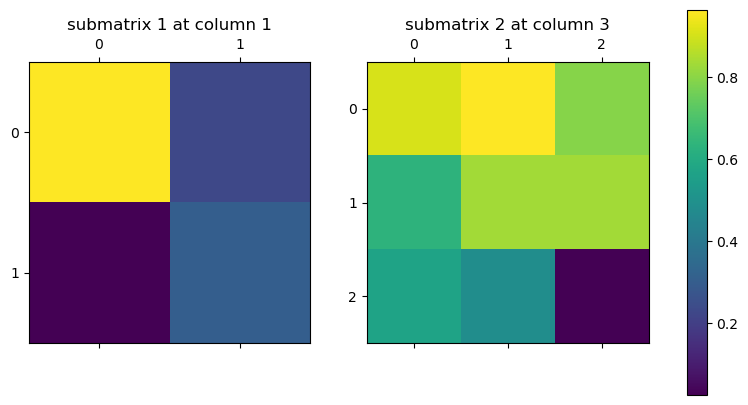

In [33]:
import matplotlib.patches as patches

# insert postions ,where the splitting will take place
pos_zeros = [0, 2, 5]
print("Assume zeros at positions :", pos_zeros)
A = Create_random_matrix(7)
for i in pos_zeros:
    A[i + 1, i] = 0

# plot original matrix
plt.matshow(np.abs(A))
# plot zeros (red dots)
for i in pos_zeros:
    plt.plot(i, i + 1, "rs")

# plot frame around submatrices
rect0 = patches.Rectangle(
    (-0.5, -0.5), 1, 1, linewidth=6, edgecolor="b", facecolor="none"
)
rect1 = patches.Rectangle(
    (0.5, 0.5), 2, 2, linewidth=4, edgecolor="k", facecolor="none"
)
rect2 = patches.Rectangle(
    (2.5, 2.5), 3, 3, linewidth=4, edgecolor="k", facecolor="none"
)
rect3 = patches.Rectangle(
    (5.5, 5.5), 1, 1, linewidth=6, edgecolor="b", facecolor="none"
)
ax = plt.gca()
ax.add_patch(rect0)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
plt.title("A")
plt.colorbar()
plt.show()

print(" red dots are set to 0, blue boxes are eigenvalues. The two black boxes remain.")
# split the matrix in submatrices
lst = Split(A, pos_zeros)
# plot submatrices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, mat in enumerate(lst):
    im = ax[i].matshow(np.abs(mat[0]))
    ax[i].set_title("submatrix " + str(i + 1) + " at column " + str(mat[1]))
plt.colorbar(im, ax=ax)
plt.show()

EXERCISE: The following function you already know quite well. What was modified?

#### Solution:



In [34]:
def QR_iteration(
    A,
    eps=1e-6,
    max_Iterations=10000,
    shift="None",
    check_deflation=True,
    eps_deflation=1e-10,
):
    # This function iterates the QR algorithm, until either Max iter reached, the values on the diagonal
    # converged or you could deflate the matrix. The matrix A will be overwritten.
    # INPUT : - A: squared Matrix in hessenberg form
    #         - eps: if no diag entry changes more than eps, than the algorithm is converged
    #         - max_iterations: If this number is reached, it aborts the iteration and gives a warning
    #         - shift: accelerate convergence, types: Zero, Wilkinson, Francis, Rayleigh, None,
    #                 if None Wilkinson or Francis will be selected
    #         - check_deflation: checks, if one can deflate the matrix
    #         - eps_deflation: threshhold for deflation
    # OUTPUT: - Q, nxn Matrix, similarity transformation
    #         - positions of the vanishing entries for the deflation
    #         - Iter : number of Iterations

    # define values, for the computation
    if shift == "None":
        shift = "Zero"

    n = A.shape[0]
    Iter = 0
    error_ev = 1
    diagvals = np.diag(A).copy()
    Q_res = np.eye(n, dtype=A.dtype)
    pos_zeros = []

    # start QR iteration
    while error_ev > eps and Iter < max_Iterations:
        # evaluate shifts
        sigma = np.real(evaluate_shift(A[-2:, -2:], shift))

        # QR iteration
        A[:, :] = A - sigma * np.eye(n, dtype=A.dtype)
        Q_2 = QR_decomposition_Hess(A)
        A[:, :] = A @ Q_2 + sigma * np.eye(n, dtype=A.dtype)
        Q_res[:, :] = Q_res @ Q_2
        if check_deflation:
            pos_zeros = Deflation(A, eps_deflation)
            if len(pos_zeros) > 0:
                break
        Iter += 1
        # preparation for next iteration
        error_ev = np.max(np.abs(diagvals - np.diag(A)))
        diagvals = np.diag(A).copy()

    if Iter == max_Iterations:
        print("Warning: Algorithm may not converged.")
    return Q_res, pos_zeros, Iter

The code below may be overwhelming at the first glance. Don't be afraid by this. 

In [35]:
def eigenvalue_QR(
    A, shift="None", eps_deflation=1e-10, eps_convergence=1e-6, max_Iterations=1000
):
    # calculates the eigenvalues and eigenvectors of matrix A using deflation and the QR iteration method
    # INPUT : - A squared Matrix
    #         - shift, eps_deflation, eps_convergence, max_Iterations see QR_iteration
    # OUTPUT: - eigenvalues
    #         - Q similarity transformation, it contains the eigenvectors if A is normal

    Q_res = Hessenberg_form(A)
    zero_pos = Deflation(A, eps_deflation)

    matrixList = Split(A, zero_pos)

    while matrixList != []:  # iterate until no matrix in the list
        B = matrixList[0][0]
        n_start = matrixList[0][1]
        n = B.shape[0]
        Q, pos_zeros, steps = QR_iteration(
            B,
            eps=eps_convergence,
            max_Iterations=max_Iterations,
            shift=shift,
            eps_deflation=eps_deflation,
        )

        if steps < max_Iterations:
            splitted_matrices = Split(B, pos_zeros, offset=n_start)
            matrixList += splitted_matrices

        matrixList.pop(0)  # remove matrix B from list
        Q_res[:, n_start : n_start + n] = Q_res[:, n_start : n_start + n] @ Q
    return np.diag(A), Q_res

EXERCISE: Write tests for the implementation above.

In [36]:
A = Create_random_matrix(5, "diag_dominant")
# HERE your code

## Comparison of different speed-ups
EXERCISE: Now compare the different methods for different matrix sizes. We do the first comparison for small matrices. Modify the list of shifts.

The code below uses `lambda` functions. So far, every function (`QR_slow`, `QR_iteration`,...) need different arguments. A `lambda` function create function without name.
The basic structure is:   
`lambda argument : body of function`,  
where `lambda` is a keyword, _argument_, the name of the argument, and _body of function_ your implementation.
This helps us, to set function specific arguments and leave the shared argument (our matrix A) as it is. For better explanations ask the internet, please. 

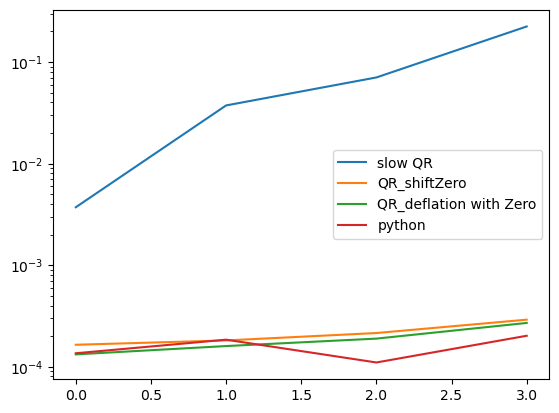

In [37]:
# enter HERE the type of shift you implemented
shifts = ["Zero"]
# the following is a dictionary of functions,
# prepare every function in such a way, that it only takes a matrix as input
# use lambda functions as helpers (see next line)
algorithms_slow = {"slow QR": lambda A: QR_iteration_slow(A)}
algorithms_shift = {
    "QR_shift" + shift: lambda A: QR_iteration(A, shift=shift) for shift in shifts
}
algorithms_deflation = {
    "QR_deflation with " + shift: lambda A: QR_iteration(
        A, shift=shift, check_deflation=True
    )
    for shift in shifts
}
algortihms_python = {"python": lambda A: np.linalg.eig(A)}
# add all dictionaries to one
algortigms = {
    **algorithms_slow,
    **algorithms_shift,
    **algorithms_deflation,
    **algortihms_python,
}
max_size = 7
times = {alg: np.zeros(max_size - 3) for alg in algortigms.keys()}
for i in range(3, max_size):
    A = laplace_matrix_square(i)
    Q = Hessenberg_form(A)
    for alg in algortigms:
        start = time.time()
        algortigms[alg](A.copy())
        end = time.time()
        times[alg][i - 3] = end - start

for alg in algortigms:
    plt.plot(times[alg], label=alg)
plt.legend()
plt.yscale("log")

Let's continue the competition without the slow version ...


Let's copy the cell from above and remove the slow version (because it's really slow...)
At this point: Again a Runtime Warning. All your unsaved data maybe lost, if pc breaks down.
Please increase the max_size slowly ! 
First set up all algorithms and then change test_all_implementations to True

/tmp/ipykernel_36022/2755426006.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


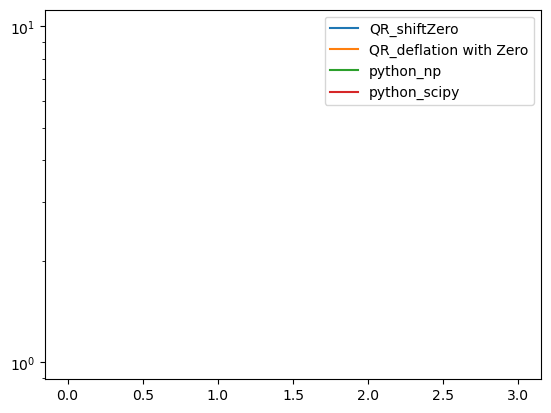

In [38]:
test_all_implementations = False
shifts = ["Zero"]
n_shifts = len(shifts)
algorithms_shift = {
    "QR_shift" + shifts[i]: lambda A: QR_iteration(
        A,
        shift=shifts[i],
    )
    for i in range(n_shifts)
}
algorithms_deflation = {
    "QR_deflation with " + shifts[i]: lambda A: QR_iteration(
        A, shift=shifts[i], check_deflation=True
    )
    for i in range(n_shifts)
}
algortihms_python = {
    "python_np": lambda A: np.linalg.eig(A),
    "python_scipy": lambda A: scl.eig(A),
}
algortigms = {**algorithms_shift, **algorithms_deflation, **algortihms_python}
max_size = 7
times = {alg: np.zeros(max_size - 3) for alg in algortigms.keys()}
if test_all_implementations:
    for i in range(3, max_size):
        A = laplace_matrix_square(i)
        B = A.copy()
        for alg in algortigms:
            if "shift" in alg:
                start = time.time()
                Q = Hessenberg_form(B)
            else:
                start = time.time()
            algortigms[alg](B)
            end = time.time()
            times[alg][i - 3] = end - start
plt.figure()
for alg in algortigms:
    plt.plot(times[alg], label=alg)
plt.legend()
plt.yscale("log")

Have you beaten python?  
What about other matrices? To get a better impression, we run 100 experiments and average the time. So the next one can take some time...



/tmp/ipykernel_36022/2184660744.py:29: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


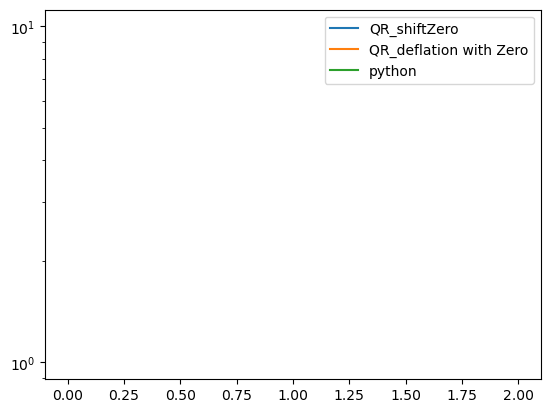

In [39]:
test_all_implementations = False
shifts = ["Zero"]
n_shifts = len(shifts)
algorithms_shift = {
    "QR_shift" + shifts[i]: lambda A: QR_iteration(
        A,
        shift=shifts[i],
    )
    for i in range(n_shifts)
}
algorithms_deflation = {
    "QR_deflation with " + shifts[i]: lambda A: QR_iteration(
        A, shift=shifts[i], check_deflation=True
    )
    for i in range(n_shifts)
}
algortihms_python = {"python": lambda A: np.linalg.eig(A)}
algortigms = {**algorithms_shift, **algorithms_deflation, **algortihms_python}
max_size = 6
times = {alg: np.zeros(max_size - 3) for alg in algortigms.keys()}
repetitions = 100
if test_all_implementations:
    for i in range(3, max_size):
        for j in range(repetitions):  # average over different random matrices
            A = Create_random_matrix(i * i, "diag_dominant")
            for alg in algortigms:
                B = A.copy()  # all algortigms use the same random matrix
                if "shift" in alg:
                    start = time.time()
                    Q = Hessenberg_form(B)
                else:
                    start = time.time()
                algortigms[alg](B)
                end = time.time()
                times[alg][i - 3] += end - start
plt.figure()
for alg in algortigms:
    plt.plot(times[alg] / repetitions, label=alg)
plt.legend()
plt.yscale("log")

## Further progress

You can choose to

- Compute the Eigenvectors
- Apply the algorithms above to more complicated problems, e.g. singular value decomposition (SVD), inverse of matrix, 
- Think about, what changes, if we use arbitrary matrices with possible complex eigenvalues? What do we have to change, if input a complex matrix?
Hint: for real matrices, complex eigenvalues appear in complex conjugated pairs only.
- Which steps can be parallelized? What is a good way to parallelize it? (independent tasks, SIMD, ...)
- Implement a sparse algorithm. This maybe a lot of work, because almost every function has to be rewritten, such that sparsity can be used. Try to beat the python implementation.
- Profile your solution. A tool for this:
```
import cProfile

A = laplace_matrix_square(11) # at least 10 seconds to calculate

cProfile.run('eigenvalue_QR(A)')
```